In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from radar_plot import radar_factory

In [2]:
sns.set_context('paper')

In [646]:
results_path = '/Users/shiveshchaudhary/Documents/projects/tracking_paper/Results_synthetic_tracking_copy_v2.xlsx'

In [647]:
reg_seq = pd.read_excel(results_path, sheet_name='Reg_OM_seq_PN0.5')
reg_alltorand = pd.read_excel(results_path, sheet_name='Reg_OM_alltorand_PN0.5')
reg_alltoone = pd.read_excel(results_path, sheet_name='Reg_OM_alltoone_PN0.5')

qap_seq = pd.read_excel(results_path, sheet_name='QAP_OM_seq_PN0.5')
qap_alltorand = pd.read_excel(results_path, sheet_name='QAP_OM_alltorand_PN0.5')
qap_alltoone = pd.read_excel(results_path, sheet_name='QAP_OM_alltoone_PN0.5')

In [648]:
def collate_data(precision, recall):
    if precision != None and recall != None:
        r_seq = reg_seq[(reg_seq['Avg Precision'] == precision) & (reg_seq['Avg Recall'] == recall)]
    else:
        r_seq = reg_seq
    r_seq = r_seq[r_seq['Run'] == 'Old']
    r_seq = r_seq[~r_seq['Method'].isin(['L2ERPM', 'PRGLS'])]
    r_seq = r_seq.drop(columns=['Run', 'Index', 'NumFrames'])
    r_seq['Tracking Strategy'] = 'Sequential'
    r_seq['Method Type'] = 'Linear'

    if precision != None and recall != None:
        r_atr = reg_alltorand[(reg_alltorand['Avg Precision'] == precision) & (reg_alltorand['Avg Recall'] == recall)]
    else:
        r_atr = reg_alltorand
    r_atr = r_atr[r_atr['Run'] == 'Old']
    r_atr = r_atr[~r_atr['Method'].isin(['L2ERPM', 'PRGLS'])]
    r_atr = r_atr.drop(columns=['Run', 'Index', 'NumFrames'])
    r_atr['Tracking Strategy'] = 'All to random'
    r_atr['Method Type'] = 'Linear'

    if precision != None and recall != None:
        r_ato = reg_alltoone[(reg_alltoone['Avg Precision'] == precision) & (reg_alltoone['Avg Recall'] == recall)]
    else:
        r_ato = reg_alltoone
    r_ato = r_ato[r_ato['Run'] == 'Old']
    r_ato = r_ato[~r_ato['Method'].isin(['L2ERPM', 'PRGLS'])]
    r_ato = r_ato.drop(columns=['Run', 'Index', 'NumFrames'])
    r_ato['Tracking Strategy'] = 'All to reference'
    r_ato['Method Type'] = 'Linear'

    if precision != None and recall != None:
        q_seq = qap_seq[(qap_seq['Avg Precision'] == precision) & (qap_seq['Avg Recall'] == recall)]
    else:
        q_seq = qap_seq
    q_seq = q_seq[q_seq['Features'] == 'All']
    q_seq = q_seq.drop(columns=['Index', 'Features'])
    q_seq['Tracking Strategy'] = 'Sequential'
    q_seq['Method Type'] = 'Quadratic'
    q_seq.loc[q_seq['Method'] == 'GW_EOT', 'Method Type'] = 'Hybrid'

    if precision != None and recall != None:
        q_atr = qap_alltorand[(qap_alltorand['Avg Precision'] == precision) & (qap_alltorand['Avg Recall'] == recall)]
    else:
        q_atr = qap_alltorand
    q_atr = q_atr[q_atr['Features'] == 'All']
    q_atr = q_atr.drop(columns=['Index', 'Features', 'Unnamed: 17'])
    q_atr['Tracking Strategy'] = 'All to random'
    q_atr['Method Type'] = 'Quadratic'
    q_atr.loc[q_atr['Method'] == 'GW_EOT', 'Method Type'] = 'Hybrid'

    if precision != None and recall != None:
        q_ato = qap_alltoone[(qap_alltoone['Avg Precision'] == precision) & (qap_alltoone['Avg Recall'] == recall)]
    else:
        q_ato = qap_alltoone
    q_ato = q_ato[q_ato['Features'] == 'All']
    q_ato = q_ato.drop(columns=['Index', 'Features', 'Unnamed: 17'])
    q_ato['Tracking Strategy'] = 'All to reference'
    q_ato['Method Type'] = 'Quadratic'
    q_ato.loc[q_ato['Method'] == 'GW_EOT', 'Method Type'] = 'Hybrid'

    data = pd.concat([
    r_seq, r_atr, r_ato,
    q_seq, q_atr, q_ato
    ])
    data['Method'] = data['Method'].str.replace("'", "")
    return data

# Fig 3A

Comparison across track link strategies

In [650]:
def fig_3a(precision, recall, metric, metric_name):

       data = collate_data(precision, recall)
       avg_data = data.groupby(['Method Type', 'Method', 'Tracking Strategy'])[metric].mean().reset_index()
       cmap = {'Linear':"#005f73", 'Quadratic':"#e07a5f", 'Hybrid':"#39b54a"}
       avg_data['color'] = avg_data['Method Type'].map(cmap)
       method_colors = dict(zip(avg_data['Method'], avg_data['color']))

       # radar plot
       spoke_labels = avg_data['Method'].unique()
       N = len(spoke_labels)
       conditions = avg_data['Tracking Strategy'].unique()
       theta = radar_factory(N, frame='polygon')

       colors = ['b', 'r', 'g']

       fig, ax = plt.subplots(figsize=(5, 5), nrows=1, ncols=1, subplot_kw=dict(projection='radar'))
       fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
       for d, color in zip(conditions, colors):
              ax.plot(theta, avg_data[avg_data['Tracking Strategy'] == d][metric], color=color)
              ax.scatter(theta, avg_data[avg_data['Tracking Strategy'] == d][metric], color=color, label='_nolegend_')
              # ax.fill(theta, avg_data[avg_data['Tracking Strategy'] == d]['obj purity'], facecolor=color, alpha=0.25, label='_nolegend_')
       
       
       ax.set_thetagrids(np.degrees(theta), spoke_labels)
       for label in ax.get_xticklabels():
              label.set_color(method_colors[label.get_text()])
       
       
       # ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
       # ax.set_rgrids([20, 40, 60, 80])
       ax.tick_params(axis='y', labelsize=12)
       ax.yaxis.grid(True, color='lightgray', linestyle='-', linewidth=0.5, alpha=0.6)
       ax.xaxis.grid(True, color='lightgray', linestyle='-', linewidth=0.5, alpha=0.7)
       ax.set_title(metric_name, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')

       legend = ax.legend(conditions, loc=(0.9, .95), labelspacing=0.1, fontsize='small')
       return fig
       
       

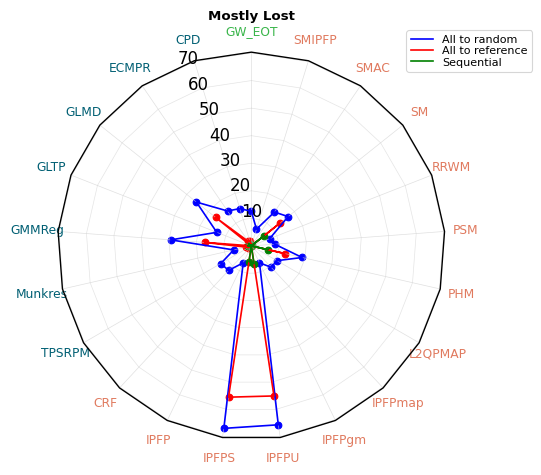

In [651]:
# fig = fig_3a(0.9, 0.9, 'obj purity', 'Object Purity')
# plt.savefig(f'/Users/shiveshchaudhary/Documents/projects/tracking_paper/figures/fig_3a_objpurity.pdf')

# fig = fig_3a(0.9, 0.9, 'track purity', 'Track Purity')
# plt.savefig(f'/Users/shiveshchaudhary/Documents/projects/tracking_paper/figures/fig_3a_trackpurity.pdf')

# fig = fig_3a(0.9, 0.9, 'track link accuracy', 'Track Link Accuracy')
# plt.savefig(f'/Users/shiveshchaudhary/Documents/projects/tracking_paper/figures/fig_3a_tracklinkacc.pdf')

# fig = fig_3a(0.9, 0.9, 'frags per gt', 'Frags per ground-truth')
# plt.savefig(f'/Users/shiveshchaudhary/Documents/projects/tracking_paper/figures/fig_3a_fragspergt.pdf')

fig = fig_3a(0.9, 0.9, 'ML', 'Mostly Lost')
# plt.savefig(f'/Users/shiveshchaudhary/Documents/projects/tracking_paper/figures/fig_3a_ml.pdf')


# Fig 3B

In [ ]:
utrack = pd.read_excel(results_path, sheet_name='utrack_PN0.5')
utrack['Method Type'] = 'utrack'
cinda = pd.read_excel(results_path, sheet_name='CINDA_PN0.5')
cinda['Method Type'] = 'CINDA'

data = pd.concat([utrack, cinda], axis=0)
data

,Video num,Avg Precision,Avg Recall,Precision,Recall,Runtime(s),track link accuracy,MT,ML,frags,length 1 frags,frags per gt,track purity,obj purity,Method Type
0,1,0.9,0.9,0.952556,0.825507,6.393536,0.558680,1,5,2409,3215,43.261538,0.497283,0.211366,utrack
1,2,0.9,0.9,0.861534,0.968254,5.114422,0.570750,1,6,2415,3084,42.300000,0.487524,0.221998,utrack
2,3,0.9,0.9,0.914660,0.985413,5.033956,0.589665,1,0,2404,2893,40.746154,0.532112,0.239982,utrack
3,4,0.9,0.9,0.859420,0.947143,4.885977,0.561388,0,1,2452,3094,42.661538,0.458460,0.209294,utrack
4,5,0.9,0.9,0.910257,0.898068,5.104277,0.589715,1,3,2363,2900,40.484615,0.496394,0.233974,utrack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,46,0.6,0.6,0.616372,0.727095,1.865444,0.614974,0,2,1960,1810,29.000000,0.608631,0.166732,CINDA
196,47,0.6,0.6,0.620453,0.567567,1.689885,0.617078,0,4,1906,1852,28.907692,0.622247,0.160833,CINDA
197,48,0.6,0.6,0.552433,0.574186,1.721204,0.615147,0,3,1912,1842,28.876923,0.571523,0.163369,CINDA
198,49,0.6,0.6,0.598164,0.648771,1.745056,0.625935,0,2,1937,1781,28.600000,0.625720,0.159276,CINDA


In [440]:
def fig_3b(precision, recall, metric, metric_name):
    tmp = data[(data['Avg Precision'] == precision) & (data['Avg Recall'] == recall)]
    fig, ax = plt.subplots(1, 1, figsize=(2, 4))
    sns.boxplot(data=tmp, x='Method Type', y=metric, ax=ax)
    ax.set_ylim([0, 40])
    ax.set_xticklabels(ax.get_xticklabels(), size=16, rotation=45)
    ax.set_yticklabels(ax.get_yticklabels(), size=16)
    ax.set_ylabel(metric_name, size=16)
    ax.set_xlabel(None)

/var/folders/k2/tls1_rjn1tz0rxf6rql8bhh40000gn/T/ipykernel_17786/2324196284.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), size=16, rotation=45)
/var/folders/k2/tls1_rjn1tz0rxf6rql8bhh40000gn/T/ipykernel_17786/2324196284.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), size=16)


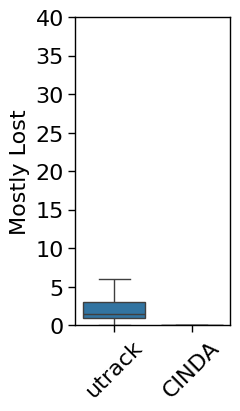

In [441]:
# fig_3b(0.9, 0.9, 'obj purity', 'Object Purity')
# plt.savefig(f'/Users/shiveshchaudhary/Documents/projects/tracking_paper/figures/fig_3b_objpurity.pdf')

# fig_3b(0.9, 0.9, 'track purity', 'Track Purity')
# plt.savefig(f'/Users/shiveshchaudhary/Documents/projects/tracking_paper/figures/fig_3b_trackpurity.pdf')

# fig_3b(0.9, 0.9, 'track link accuracy', 'Track Link Accuracy')
# plt.savefig(f'/Users/shiveshchaudhary/Documents/projects/tracking_paper/figures/fig_3b_tracklinkacc.pdf')

fig_3b(0.9, 0.9, 'ML', 'Mostly Lost')
plt.savefig(f'/Users/shiveshchaudhary/Documents/projects/tracking_paper/figures/fig_3b_ml.pdf')

# fig_3b(0.9, 0.9, 'frags per gt', 'Frags per ground-truth')
# plt.savefig(f'/Users/shiveshchaudhary/Documents/projects/tracking_paper/figures/fig_3b_fragspergt.pdf')

# Fig 4A

In [466]:
def fig_4a(precision, recall):
    data = collate_data(precision, recall)

    tmp = data[data['Tracking Strategy'] == 'All to reference']
    tmp = tmp.groupby(['Method Type', 'Method']).agg(
        mean_obj_purity=('obj purity', 'mean'),
        std_obj_purity=('obj purity', 'std'),
        mean_runtime=('Runtime(s)', 'mean'),
        std_runtime=('Runtime(s)', 'std')).reset_index()
    tmp_linear = tmp[tmp['Method Type'] == 'Linear']
    tmp_quad = tmp[tmp['Method Type'] == 'Quadratic']
    tmp_hyb = tmp[tmp['Method Type'] == 'Hybrid']

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    ax.errorbar(tmp_linear['mean_runtime'], tmp_linear['mean_obj_purity'],
                yerr=tmp_linear['std_obj_purity'], xerr=tmp_linear['std_runtime'], fmt='o', c="#005f73", 
                capsize=4, label='Linear Methods')
    ax.errorbar(tmp_quad['mean_runtime'], tmp_quad['mean_obj_purity'],
                yerr=tmp_quad['std_obj_purity'], xerr=tmp_quad['std_runtime'], fmt='o', c="#e07a5f", 
                capsize=4, label='Quadratic Methods')
    ax.errorbar(tmp_hyb['mean_runtime'], tmp_hyb['mean_obj_purity'],
                yerr=tmp_hyb['std_obj_purity'], xerr=tmp_hyb['std_runtime'], fmt='o', c="#39b54a", 
                capsize=4, label='Hybrid Methods')
    for idx, row in tmp_linear.iterrows():
        ax.text(x=row['mean_runtime']*1.4, y=row['mean_obj_purity'], s=row['Method'], size=11)
    for idx, row in tmp_quad.iterrows():
        ax.text(x=row['mean_runtime']*1.4, y=row['mean_obj_purity'], s=row['Method'], size=11)
    for idx, row in tmp_hyb.iterrows():
        ax.text(x=row['mean_runtime']*1.4, y=row['mean_obj_purity'], s=row['Method'], size=11)
    ax.set_ylim([0.2, 1.02])
    ax.set_xscale('log')
    ax.set_xticklabels(ax.get_xticklabels(), size=16)
    ax.set_yticklabels(ax.get_yticklabels(), size=16)
    ax.set_xlabel('Average Runtime (s)', size=16)
    ax.set_ylabel('Object Purity', size=16)
    ax.set_title(f'Precision/Recall = {precision}', size=16)
    ax.legend(fontsize=14)
    fig.tight_layout()


/var/folders/k2/tls1_rjn1tz0rxf6rql8bhh40000gn/T/ipykernel_17786/556903967.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), size=16)
/var/folders/k2/tls1_rjn1tz0rxf6rql8bhh40000gn/T/ipykernel_17786/556903967.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), size=16)
/var/folders/k2/tls1_rjn1tz0rxf6rql8bhh40000gn/T/ipykernel_17786/556903967.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), size=16)
/var/folders/k2/tls1_rjn1tz0rxf6rql8bhh40000gn/T/ipykernel_17786/556903967.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

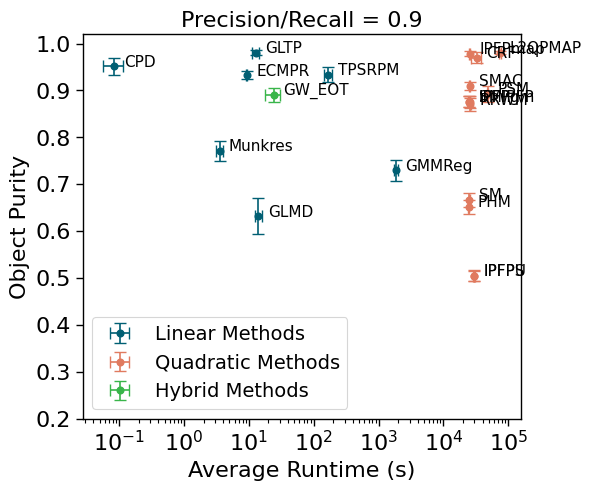

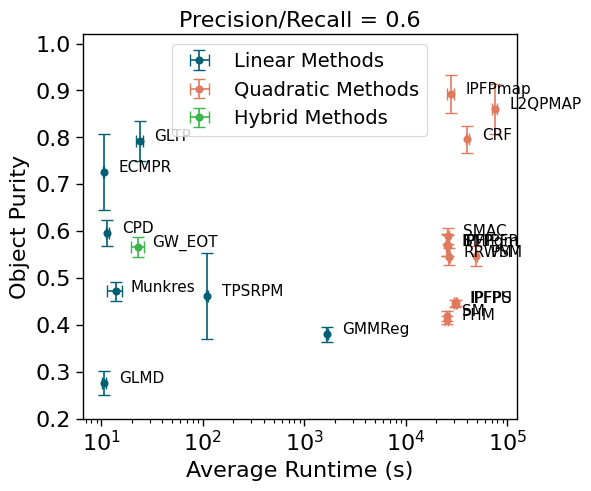

In [468]:
fig_4a(0.9, 0.9)
plt.savefig('/Users/shiveshchaudhary/Documents/projects/tracking_paper/figures/fig4a_p0.9.png', dpi=300)

fig_4a(0.6, 0.6)
plt.savefig('/Users/shiveshchaudhary/Documents/projects/tracking_paper/figures/fig4a_p0.6.png', dpi=300)

# Fig 4B

In [469]:
data = collate_data(None, None)
data

,Video num,Avg Precision,Avg Recall,Precision,Recall,Runtime(s),track link accuracy,MT,ML,frags,length 1 frags,frags per gt,track purity,obj purity,Method,Tracking Strategy,Method Type
0,1,0.9,0.9,0.956943,0.924989,0.118067,0.833964,27,0,1658,482,16.461538,0.873426,0.227547,CPD,Sequential,Linear
1,2,0.9,0.9,0.925298,0.878216,0.054275,0.846846,28,0,1607,389,15.353846,0.880863,0.240294,CPD,Sequential,Linear
2,3,0.9,0.9,0.869891,0.987023,0.059539,0.842635,25,0,1625,416,15.700000,0.876558,0.233576,CPD,Sequential,Linear
3,4,0.9,0.9,1.020123,0.949968,0.059351,0.839863,37,0,1601,464,15.884615,0.875125,0.239895,CPD,Sequential,Linear
4,5,0.9,0.9,0.913010,0.913217,0.064000,0.833189,22,0,1665,507,16.707692,0.873379,0.225704,CPD,Sequential,Linear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3964,1,0.6,0.6,0.630719,0.576824,25.840110,0.404434,0,100,1210,4760,45.923077,0.955457,0.567135,GW_EOT,All to reference,Hybrid
3965,1,0.6,0.6,0.538177,0.542340,17.921741,0.407527,0,88,1111,4808,45.530769,0.957142,0.568822,GW_EOT,All to reference,Hybrid
3966,1,0.6,0.6,0.674992,0.640166,17.468556,0.399795,0,99,1146,4873,46.300000,0.956227,0.557259,GW_EOT,All to reference,Hybrid
3967,1,0.6,0.6,0.608777,0.585304,19.481352,0.446179,0,84,1278,4504,44.476923,0.947329,0.597946,GW_EOT,All to reference,Hybrid


In [482]:
def fig_4b(metric, metric_name):
    tmp = data[data['Tracking Strategy'] == 'All to reference']
    best_score = tmp[tmp['Avg Precision'] == 0.9].groupby(['Method Type', 'Method'])['obj purity'].mean().reset_index().rename(columns={'obj purity':'best_score'})
    # best_score = tmp[tmp['Avg Precision'] == 0.9].groupby(['Method Type', 'Method'])[metric].mean().reset_index().rename(columns={f'{metric}':'best_score'})
    tmp = tmp.merge(best_score, on=['Method Type', 'Method'], how='left')
    tmp = tmp.sort_values(by=['best_score'], ascending=False)
    cmap = {'Linear':"#005f73", 'Quadratic':"#e07a5f", 'Hybrid':"#39b54a"}
    tmp['color'] = tmp['Method Type'].map(cmap)

    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    sns.boxplot(data=tmp, x='Method', y=metric, hue='Avg Precision', palette='light:blue', showfliers=False)

    ax.set_ylim([-5, 140])
    ax.set_xlim([-0.5, 20.5])
    mcolor = tmp[['Method', 'color']].drop_duplicates()
    mcolor = dict(zip(mcolor['Method'], mcolor['color']))
    for label in ax.get_xticklabels():
        label.set_color(mcolor[label.get_text()])

    ax.set_xticklabels(ax.get_xticklabels(), size=16, rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), size=16)
    ax.set_xlabel('Method', size=16)
    ax.set_ylabel(metric_name, size=16)
    ax.set_title(f'Effect of noise on accuracy', size=16)
    ax.legend(fontsize=14)
    xticks = ax.get_xticks()
    n_xticks = [(xticks[i] + xticks[i + 1])/2 for i in range(len(xticks) - 1)]
    ax.vlines(n_xticks, -5, 140, color='k', linestyles='--', linewidth=0.5)
    fig.tight_layout()

/var/folders/k2/tls1_rjn1tz0rxf6rql8bhh40000gn/T/ipykernel_17786/582636647.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), size=16, rotation=90)
/var/folders/k2/tls1_rjn1tz0rxf6rql8bhh40000gn/T/ipykernel_17786/582636647.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), size=16)


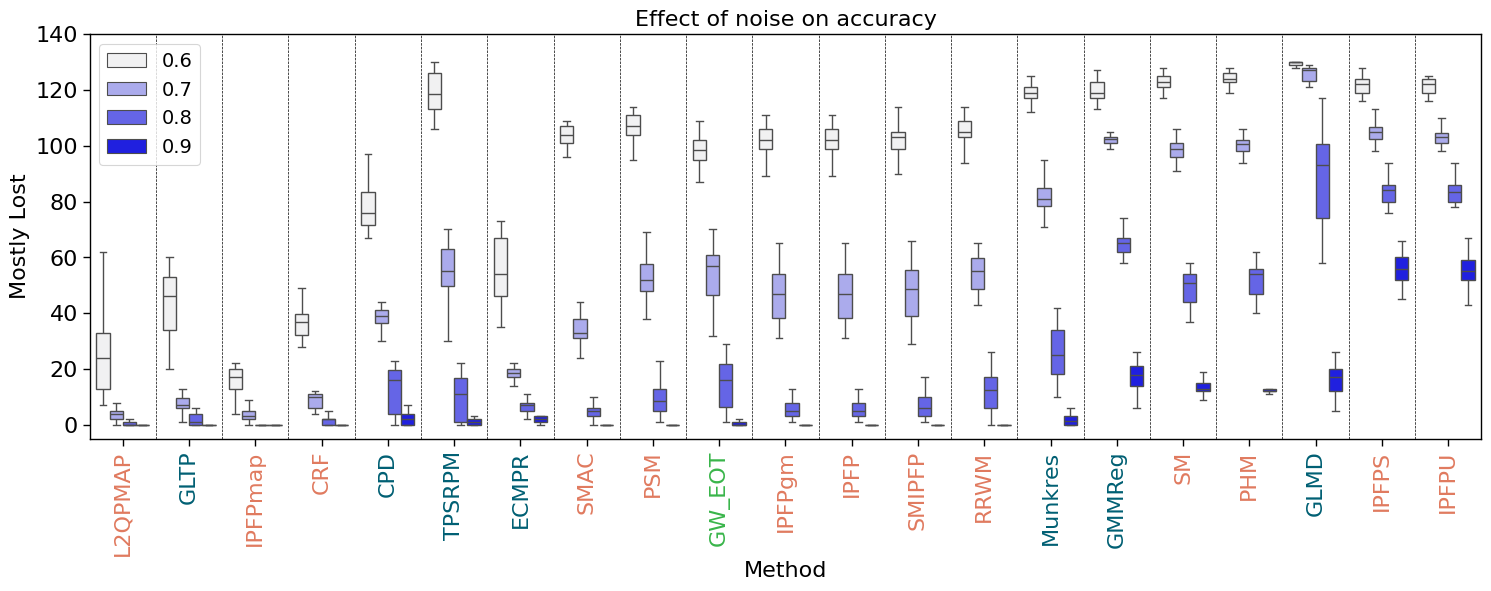

In [483]:
fig_4b('ML', 'Mostly Lost')
plt.savefig('/Users/shiveshchaudhary/Documents/projects/tracking_paper/figures/fig4supp_mostlylost.png', dpi=300)

# Fig 5A

In [489]:
data1 = collate_data(0.9, 0.9)
data2 = collate_data(0.6, 0.6)

tmp1 = data1[data1['Tracking Strategy'] == 'All to reference']
tmp1 = tmp1.groupby(['Method Type', 'Method']).agg(
    {'obj purity':'mean',
    'track purity':'mean',
    'track link accuracy':'mean',
    'MT':'mean',
    'ML':'mean',
    'frags per gt':'mean'}).reset_index()

tmp1['frags per gt'] = (tmp1['frags per gt'] - tmp1['frags per gt'].min())/(tmp1['frags per gt'].max() - tmp1['frags per gt'].min())
tmp1['ML'] = (tmp1['ML'] - tmp1['ML'].min())/(tmp1['ML'].max() - tmp1['ML'].min())

tmp2 = data2[data2['Tracking Strategy'] == 'All to reference']
tmp2 = tmp2.groupby(['Method Type', 'Method'])['obj purity'].mean().reset_index().rename(columns={'obj purity':'obj purity at 0.6'})

tmp1 = tmp1.merge(tmp2, on=['Method Type', 'Method'])
tmp1['robustness score'] = 1 - (tmp1['obj purity'] - tmp1['obj purity at 0.6'])/tmp1['obj purity']

cmap = {'Linear':"#005f73", 'Quadratic':"#e07a5f", 'Hybrid':"#39b54a"}
tmp1['color'] = tmp1['Method Type'].map(cmap)

# change plot order
tmp1 = pd.concat([
    tmp1[tmp1['Method Type'] == 'Linear'],
    tmp1[tmp1['Method Type'] == 'Hybrid'],
    tmp1[tmp1['Method Type'] == 'Quadratic']], axis=0)
tmp1

,Method Type,Method,obj purity,track purity,track link accuracy,MT,ML,frags per gt,obj purity at 0.6,robustness score,color
1,Linear,CPD,0.951269,0.981330,0.919881,44.840000,0.036745,0.154191,0.596462,0.627018,#005f73
2,Linear,ECMPR,0.932117,0.988304,0.886314,37.272727,0.036025,0.199792,0.726397,0.779298,#005f73
3,Linear,GLMD,0.631540,0.849917,0.465023,0.181818,0.298024,0.783664,0.276273,0.437460,#005f73
4,Linear,GLTP,0.980030,0.978084,0.964677,55.151515,0.001092,0.091702,0.792673,0.808825,#005f73
5,Linear,GMMReg,0.729469,0.989673,0.593082,5.090909,0.304574,0.605184,0.380125,0.521098,#005f73
6,Linear,Munkres,0.771319,0.717789,0.642209,1.960000,0.035304,0.537107,0.471509,0.611303,#005f73
7,Linear,TPSRPM,0.933458,0.967530,0.885255,29.696970,0.022925,0.201429,0.461604,0.494510,#005f73
0,Hybrid,GW_EOT,0.890359,0.967844,0.810064,12.306122,0.008822,0.304095,0.566140,0.635857,#39b54a
8,Quadratic,CRF,0.969963,0.974700,0.947470,50.818182,0.002047,0.000000,0.795566,0.820202,#e07a5f
9,Quadratic,IPFP,0.875789,0.815867,0.781870,3.733333,0.000000,0.345130,0.569378,0.650132,#e07a5f


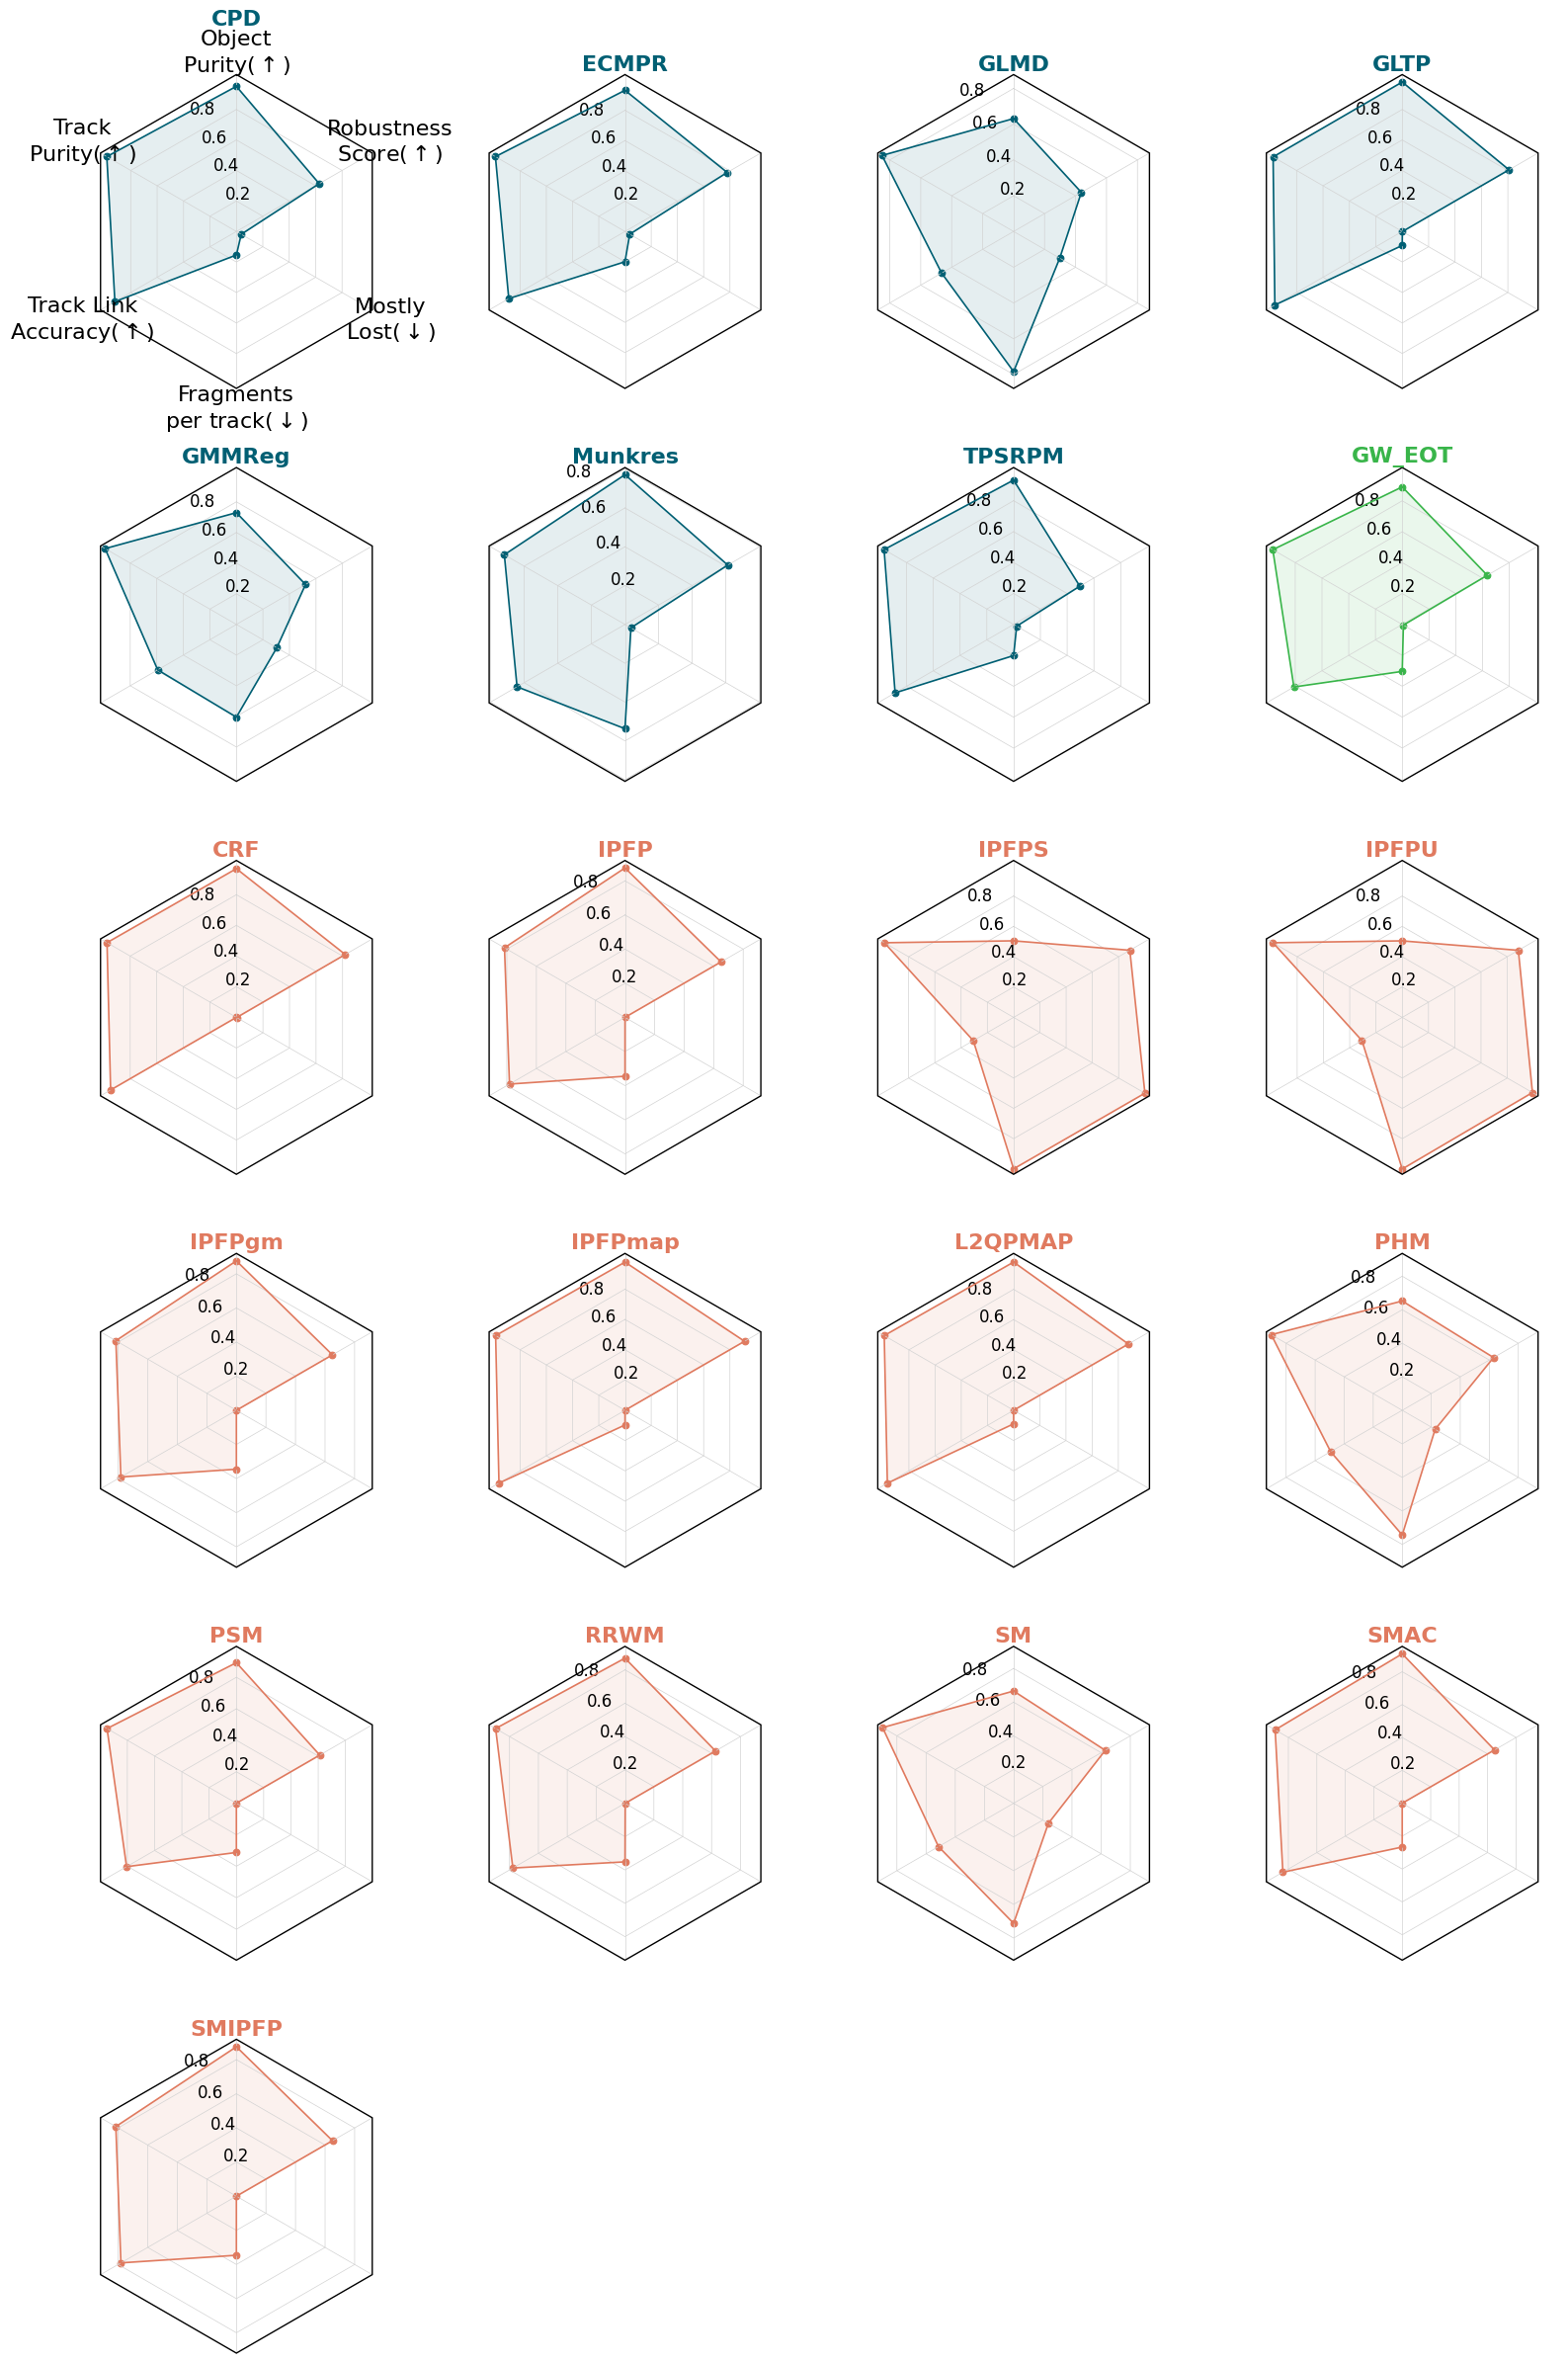

In [491]:
# radar plot
metrics = {
     'obj purity': 'Object\nPurity($\\uparrow$)',
     'track purity': 'Track\nPurity($\\uparrow$)',
     'track link accuracy': 'Track Link\nAccuracy($\\uparrow$)',
     'frags per gt': 'Fragments\nper track($\\downarrow$)',
     'ML': 'Mostly\nLost($\\downarrow$)',
     'robustness score': 'Robustness\nScore($\\uparrow$)',}


theta = radar_factory(len(metrics), frame='polygon')

N = len(tmp1)
n_cols = 4
if N%n_cols == 0:
    n_rows = N//n_cols
else:
    n_rows = N//n_cols + 1

fig, ax = plt.subplots(figsize=(4*n_cols, 4*n_rows), nrows=n_rows, ncols=n_cols, subplot_kw=dict(projection='radar'))

for i in range(len(tmp1)):
        subplot_row = i//n_cols
        subplot_col = i%n_cols
        ax[subplot_row, subplot_col].plot(theta, tmp1.iloc[i][metrics.keys()].values, color=tmp1.iloc[i]['color'])
        ax[subplot_row, subplot_col].scatter(theta, tmp1.iloc[i][metrics.keys()].values, color=tmp1.iloc[i]['color'], label='_nolegend_')
        ax[subplot_row, subplot_col].fill(theta, tmp1.iloc[i][metrics.keys()].values, facecolor=tmp1.iloc[i]['color'], alpha=0.1, label='_nolegend_')
        if i == 0:
                ax[subplot_row, subplot_col].set_thetagrids(np.degrees(theta), metrics.values(), size=16)
        else:
                ax[subplot_row, subplot_col].set_thetagrids(np.degrees(theta), '')
        ax[subplot_row, subplot_col].set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax[subplot_row, subplot_col].tick_params(axis='y', labelsize=12)
        ax[subplot_row, subplot_col].yaxis.grid(True, color='lightgray', linestyle='-', linewidth=0.5, alpha=1)
        ax[subplot_row, subplot_col].xaxis.grid(True, color='lightgray', linestyle='-', linewidth=0.5, alpha=1)
        ax[subplot_row, subplot_col].set_title(tmp1.iloc[i]['Method'], weight='bold', size=16, color=tmp1.iloc[i]['color'], position=(0.5, 1.1), horizontalalignment='center', verticalalignment='center')
        # legend = ax.legend(conditions, loc=(0.9, .95), labelspacing=0.1, fontsize='small')

tot_plots = n_rows*n_cols
for i in range(N, tot_plots):
      subplot_row = i//n_cols
      subplot_col = i%n_cols
      ax[subplot_row, subplot_col].set_axis_off()

fig.tight_layout()
plt.savefig('/Users/shiveshchaudhary/Documents/projects/tracking_paper/figures/fig5supp.png', dpi=300)

# Fig 6B

In [709]:
results_path = '/Users/shiveshchaudhary/Documents/projects/tracking_paper/Results_tracking_v2.xlsx'

reg_seq = pd.read_excel(results_path, sheet_name='20191113_w3_ctrl_reg_seq')
reg_alltoone = pd.read_excel(results_path, sheet_name='20191113_w3_ctrl_reg_alltoone')

qap_seq = pd.read_excel(results_path, sheet_name='20101113_w3_ctrl_QAP_seq')
qap_alltoone = pd.read_excel(results_path, sheet_name='20191113_w3_ctrl_QAP_alltoone')


In [710]:
r_seq = reg_seq[reg_seq['Unnamed: 12'] == 'mean centered']
r_seq = r_seq.drop(columns=['Data type', 'Unnamed: 12'])
r_seq['Tracking Strategy'] = 'Sequential'
r_seq['Method Type'] = 'Linear'

r_ato = reg_alltoone.drop(columns=['Data type'])
r_ato['Tracking Strategy'] = 'All to reference'
r_ato['Method Type'] = 'Linear'

q_seq = qap_seq[qap_seq['Category'] == 'Angle only']
q_seq = q_seq.drop(columns=['Data type', 'Category'])
q_seq['Tracking Strategy'] = 'Sequential'
q_seq['Method Type'] = 'Quadratic'
q_seq.loc[q_seq['Method'] == 'GW_EOT', 'Method Type'] = 'Hybrid'

q_ato = qap_alltoone[qap_alltoone['Category'] == 'Angle only']
q_ato = q_ato.drop(columns=['Data type', 'Index', 'Category'])
q_ato['Tracking Strategy'] = 'All to reference'
q_ato['Method Type'] = 'Quadratic'
q_ato.loc[q_ato['Method'] == 'GW_EOT', 'Method Type'] = 'Hybrid'

data = pd.concat([r_seq, r_ato, q_seq, q_ato], axis=0)
data


,Method,Vid,runtime (s),track link accuracy,MT,ML,frags,length_1_frags,frags_per_gt,track_purity,obj_purity,Tracking Strategy,Method Type
0,CPD,1,2.169951,0.954892,45,0,335,118,10.066667,0.859914,0.512106,Sequential,Linear
1,ECMPR,2,5.934006,0.854063,32,0,945,420,30.333333,0.854987,0.238143,Sequential,Linear
2,GLTP,3,3.591829,0.955998,45,0,336,107,9.844444,0.888657,0.478607,Sequential,Linear
3,GMMReg,4,3297.091369,0.950580,45,0,377,115,10.933333,0.931178,0.484135,Sequential,Linear
4,Munkres,5,0.411639,0.984301,45,0,150,37,4.155556,0.747816,0.747706,Sequential,Linear
...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,GW_EOT,16,3.619305,0.804556,23,1,530,1274,40.088889,0.994356,0.794778,All to reference,Hybrid
636,GW_EOT,17,3.790463,0.846556,30,0,469,957,31.688889,0.994021,0.842333,All to reference,Hybrid
637,GW_EOT,18,3.653505,0.846667,27,1,456,969,31.666667,0.994577,0.845111,All to reference,Hybrid
638,GW_EOT,19,3.551839,0.834667,33,0,457,1076,34.066667,0.993995,0.824889,All to reference,Hybrid


In [720]:
def fig_6b(metric, metric_name):
       avg_data = data.groupby(['Method Type', 'Method', 'Tracking Strategy'])[metric].mean().reset_index()
       cmap = {'Linear':"#005f73", 'Quadratic':"#e07a5f", 'Hybrid':"#39b54a"}
       avg_data['color'] = avg_data['Method Type'].map(cmap)
       method_colors = dict(zip(avg_data['Method'], avg_data['color']))

       # radar plot
       spoke_labels = avg_data['Method'].unique()
       N = len(spoke_labels)
       conditions = avg_data['Tracking Strategy'].unique()
       theta = radar_factory(N, frame='polygon')

       colors = ['r', 'g']
       fig, ax = plt.subplots(figsize=(5, 5), nrows=1, ncols=1, subplot_kw=dict(projection='radar'))
       fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
       for d, color in zip(conditions, colors):
              ax.plot(theta, avg_data[avg_data['Tracking Strategy'] == d][metric], color=color)
              ax.scatter(theta, avg_data[avg_data['Tracking Strategy'] == d][metric], color=color, label='_nolegend_')
              # ax.fill(theta, avg_data[avg_data['Tracking Strategy'] == d]['obj purity'], facecolor=color, alpha=0.25, label='_nolegend_')
       
       
       ax.set_thetagrids(np.degrees(theta), spoke_labels, c='#005f73', size=12)
       for label in ax.get_xticklabels():
              label.set_color(method_colors[label.get_text()])
       
       
       # ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
       # ax.set_rgrids([10, 20, 30, 40])
       # ax.set_rgrids([50, 100, 150, 200])
       ax.tick_params(axis='y', labelsize=12)
       ax.yaxis.grid(True, color='lightgray', linestyle='-', linewidth=0.5, alpha=0.6)
       ax.xaxis.grid(True, color='lightgray', linestyle='-', linewidth=0.5, alpha=0.7)
       ax.set_title(metric_name, size=16,
                     horizontalalignment='center', verticalalignment='center')

       # legend = ax.legend(conditions, loc=(0.9, .95), labelspacing=0.1, fontsize=12)
       fig.tight_layout()

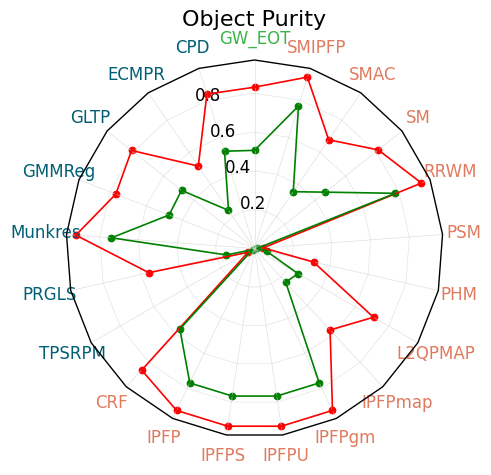

In [722]:
fig_6b('obj_purity', 'Object Purity')
plt.savefig('/Users/shiveshchaudhary/Documents/projects/tracking_paper/figures/fig6b_objpurity.png', dpi=300)

# fig_6b('track_purity', 'Track Purity')
# plt.savefig('/Users/shiveshchaudhary/Documents/projects/tracking_paper/figures/fig6bsupp_trackpurity.png', dpi=300)

# fig_6b('track link accuracy', 'Track Link Accuracy')
# plt.savefig('/Users/shiveshchaudhary/Documents/projects/tracking_paper/figures/fig6bsupp_tracklinkacc.png', dpi=300)

# fig_6b('ML', 'Mostly Lost\ntracks count')
# plt.savefig('/Users/shiveshchaudhary/Documents/projects/tracking_paper/figures/fig6bsupp_mostlylost.png', dpi=300)

# fig_6b('frags_per_gt', 'Fragments per\nground-truth track count')
# plt.savefig('/Users/shiveshchaudhary/Documents/projects/tracking_paper/figures/fig6bsupp_fragspergt.png', dpi=300)


# Fig 6C

In [ ]:
results_path = '/Users/shiveshchaudhary/Documents/projects/tracking_paper/Results_tracking_v2.xlsx'
qap_alltoone_n = pd.read_excel(results_path, sheet_name='20191113_w3_ctrl_QAP_alltoone_n')

data = qap_alltoone_n[qap_alltoone_n['Category'].isin(['AngleOnly', 'Linear'])]
data = data[~(data['loc sigma'] == 0.2)]
data = data[~(data['Precision/Recall'] == 1)]
data['Method'] = data['Method'].str.replace("'", "")
data['Method Type'] = 'Quadratic'
data.loc[data['Method'] == 'GW_EOT', 'Method Type'] = 'Hybrid'
data.loc[data['Category'] == 'Linear', 'Method Type'] = 'Linear'
data = data.drop(columns=['Index', 'Category', 'loc sigma'])
data

,Method,Precision,Recall,Vid,runtime (s),track link accuracy,MT,ML,frags,length_1_frags,frags_per_gt,track_purity,obj_purity,Data type,Precision/Recall,Method Type
80,GW_EOT,0.626345,0.538134,1,7.752228,0.417971,0,41,325,2662,69.465116,0.991316,0.370164,3D,0.6,Hybrid
81,GW_EOT,0.634429,0.448065,2,6.734023,0.493482,0,45,306,2498,59.659574,0.987268,0.326468,3D,0.6,Hybrid
82,GW_EOT,0.555808,0.471388,3,6.264466,0.441741,0,51,312,2754,58.961538,0.983048,0.331040,3D,0.6,Hybrid
83,GW_EOT,0.627595,0.561860,4,8.543051,0.517759,0,44,318,2381,58.673913,0.988775,0.355178,3D,0.6,Hybrid
84,GW_EOT,0.549525,0.556889,5,7.038920,0.424463,0,50,345,2910,63.823529,0.983394,0.337586,3D,0.6,Hybrid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2871,CRF,0.916052,0.858522,8,411.382960,0.601386,0,5,1139,2007,71.500000,0.983007,0.716080,3D,0.9,Quadratic
2872,CRF,0.591092,0.554362,9,513.705914,0.551106,0,44,474,1973,54.377778,0.977603,0.509740,3D,0.6,Quadratic
2873,CRF,0.758010,0.763746,9,517.366572,0.462479,0,38,785,2753,72.204082,0.967880,0.538036,3D,0.7,Quadratic
2874,CRF,0.768065,0.791655,9,396.495137,0.380711,0,19,786,2925,100.297297,0.991416,0.482831,3D,0.8,Quadratic


In [587]:
def fig_6c(metric, metric_name):
    tmp = data
    best_score = tmp[tmp['Precision/Recall'] == 0.9].groupby(['Method Type', 'Method'])['obj_purity'].mean().reset_index().rename(columns={'obj_purity':'best_score'})
    # best_score = tmp[tmp['Avg Precision'] == 0.9].groupby(['Method Type', 'Method'])[metric].mean().reset_index().rename(columns={f'{metric}':'best_score'})
    tmp = tmp.merge(best_score, on=['Method Type', 'Method'], how='left')
    tmp = tmp.sort_values(by=['best_score'], ascending=False)
    cmap = {'Linear':"#005f73", 'Quadratic':"#e07a5f", 'Hybrid':"#39b54a"}
    tmp['color'] = tmp['Method Type'].map(cmap)

    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    sns.boxplot(data=tmp, x='Method', y=metric, hue='Precision/Recall', palette='light:blue', showfliers=False)

    ax.set_ylim([40, 180])
    ax.set_xlim([-0.5, 20.5])
    mcolor = tmp[['Method', 'color']].drop_duplicates()
    mcolor = dict(zip(mcolor['Method'], mcolor['color']))
    for label in ax.get_xticklabels():
        label.set_color(mcolor[label.get_text()])

    ax.set_xticklabels(ax.get_xticklabels(), size=16, rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), size=16)
    ax.set_xlabel('Method', size=16)
    ax.set_ylabel(metric_name, size=16)
    ax.set_title(f'Effect of noise on accuracy', size=16)
    ax.legend(fontsize=14)
    xticks = ax.get_xticks()
    n_xticks = [(xticks[i] + xticks[i + 1])/2 for i in range(len(xticks) - 1)]
    ax.vlines(n_xticks, 40, 180, color='k', linestyles='--', linewidth=0.5)
    fig.tight_layout()

/var/folders/k2/tls1_rjn1tz0rxf6rql8bhh40000gn/T/ipykernel_17786/1327493206.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), size=16, rotation=90)
/var/folders/k2/tls1_rjn1tz0rxf6rql8bhh40000gn/T/ipykernel_17786/1327493206.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), size=16)


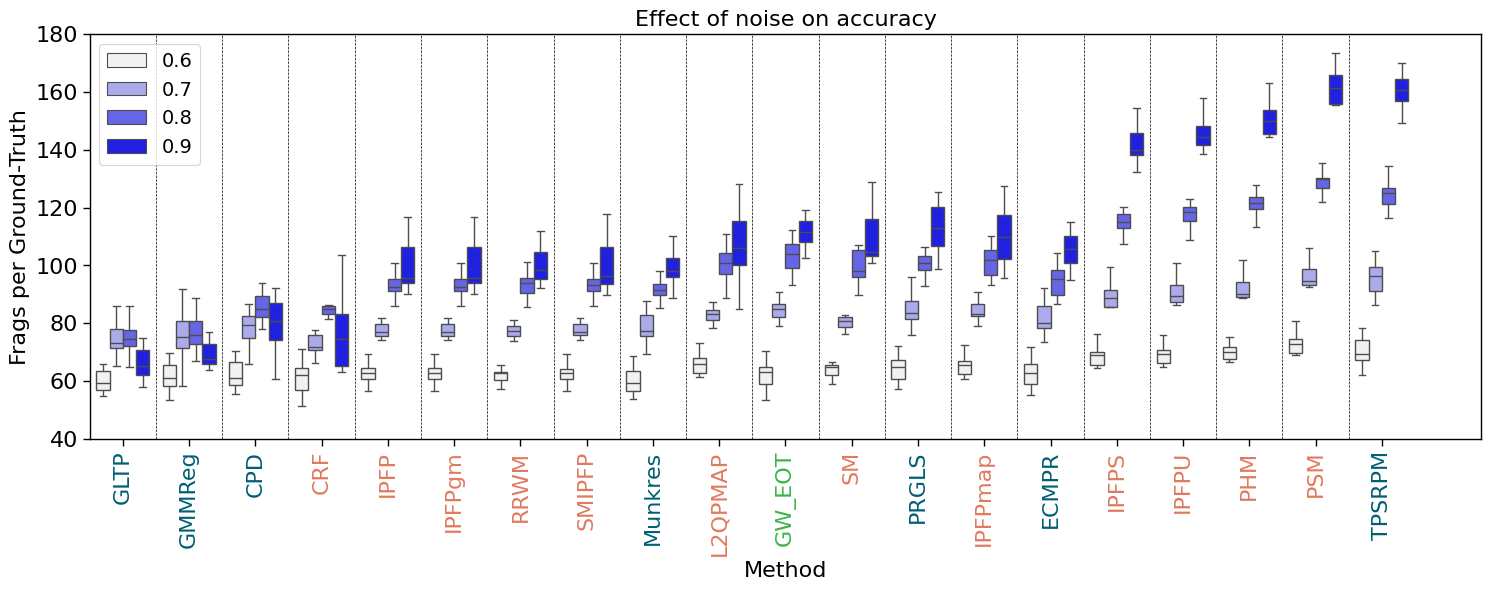

In [589]:
fig_6c('frags_per_gt', 'Frags per Ground-Truth')
plt.savefig('/Users/shiveshchaudhary/Documents/projects/tracking_paper/figures/fig6csupp_fragspergt.png', dpi=300)